## Setup dependencies

In [2]:
import sys
import datetime as dt;

# display python version and date/time
from numpy import iterable
print(dt.datetime.today());
print(sys.version)

# google colab specific code
if 'google.colab' in sys.modules:
    try:
        import google.colab
        import subprocess
        import os.path
        p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
        if p.stdout == 'true\n':
            !git pull
        else:
            if not os.path.isdir('city_dsp_ap'):
                !git clone --depth 1 -q https://github.com/jpauwels/city_dsp_ap.git
            %cd city_dsp_ap
    except:
        %cd city_dsp_ap
else:
    print("Skipped google colab specific code");

2021-03-01 16:34:53.118448
3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Skipped google colab specific code


In [3]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display

plt.rcParams['figure.figsize'] = (13,6) # increase the default size of the plots

## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal,
where the effect can be dynamically modified by a control signal. The functions only need
to be implemented for offline use, so you don't need to be handle input buffers of arbitrary
sizes like in lab 6. It suffices to use a single for loop to run over all samples of the
input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required
length yourself. Any signal should work as input signal. You can learn how
to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb)
into Google Colab, but the easiest will be to use one of the wave files available in
the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into
a single mono channel before passing it to the effect to simplify processing.

In [4]:
%ls audio

 Volume in drive C is OS
 Volume Serial Number is F287-2376

 Directory of C:\Users\jacqu\city\DS2020\Modules\DigitalSignalProcessing\Coursework\CourseworkWip\audio

13/02/2021  11:04    <DIR>          .
13/02/2021  11:04    <DIR>          ..
13/02/2021  10:45            51,328 20-16000HzExp5sec.mp3
13/02/2021  10:45            51,328 20-16000HzLin5sec.mp3
13/02/2021  10:45            34,660 carrier.wav
13/02/2021  10:45         4,365,330 rockA.wav
13/02/2021  10:45         4,365,396 rockB.wav
               5 File(s)      8,868,042 bytes
               2 Dir(s)  105,927,806,976 bytes free


#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time
in response to a control signal. Apply the filter to the signal by implementing a convolution
with the filter coefficients in a loop over the samples, just like in lab 7. In order to make
the filter respond to the control signal, you can either design two static filters and
interpolate between them (like in lab 7), or you can directly manipulate the filter
characteristics in the filter design
function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

In [5]:
# Define wav filename used:
s1Filename = "audio/carrier.wav"
s2Filename = "audio/rockA.wav"
s3Filename = "audio/rockB.wav"

In [6]:
#
# Code for audio file loading and conversion to mono
#

# Plot stereo samples, and mono samples on the same graph to see the result of
# a conversion from stereo to mono
# input stereo: 2d array format: [samples,channel]
#       monoSamples: 1d array of samples
#       title: title to give to the plot
def plotStereo(stereo, monoSamples, title):
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot(stereo[:,0], label="Ch. 1", alpha=0.35, color='green')
    ax1.plot(stereo[:,1], label="Ch. 2", alpha=0.35, color='orange')
    ax1.plot(monoSamples, label="Mono", alpha=0.35, color='blue')
    ax1.legend(loc = 4)
    ax1.set_xlabel("Sample Number")
    ax1.set_ylabel("Amplitude")
    plt.show()

# Plot monophonic (mono) samples
#       monoSamples: 1d array of samples
#       title: title to give to the plot
def plotMono(monoSamples, title):
    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.plot(monoSamples, 'b')
    ax1.set_xlabel("Sample Number")
    ax1.set_ylabel("Amplitude")
    plt.show()

# Using Audacity, on RockA.wav, it can be seen that the stereo channels are not in phase,
# and one channel has been inverted. This function finds how many samples to shift and invert
# the respective channels
# Input: stereo 2d list of channel1 and channel2 samples
#        sampleRate: sampling rate
# Output: unchanged stereo if no good correlation found, corrected samples otherwise.
def alignSamples(stereo, sampleRate):
    correlationCoefficients1 = np.zeros(sampleRate)
    correlationCoefficients = np.zeros(sampleRate)
    channel1Section = stereo[0:sampleRate,0] * -1
    channel2Section = stereo[0:sampleRate,1]
    channel1RightShift = channel1Section
    maxCoefficient = 0.0
    maxCoefficientIndex = 0

    for offset in range(0,int(sampleRate/10)):
        rawCoeff = np.dot(stereo[:, 0], stereo[:, 1]) / np.sqrt(np.dot(stereo[:, 0], stereo[:, 0]) * np.dot(stereo[:, 1], stereo[:, 1]))
        correlationCoefficients[offset] = np.dot(channel1RightShift, channel2Section) / np.sqrt(np.dot(channel1RightShift, channel1RightShift) * np.dot(channel2Section, channel2Section))
        channel1RightShift = np.concatenate([np.zeros(1), channel1RightShift])
        channel2Section = np.concatenate([channel2Section, np.zeros(1)])
        if maxCoefficient < correlationCoefficients[offset]:
            maxCoefficient = correlationCoefficients[offset]
            maxCoefficientIndex = offset
    # plot all correlation coefficients calculated
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(correlationCoefficients[0:maxCoefficientIndex+10])
    ax.set_title("correlationCoefficients")
    ax.set_xlabel("Channel 1 right shift value")
    ax.set_ylabel("Channel 1&2 correlation coefficient")
    # set xaxis labels
    ticks = np.array(range(maxCoefficientIndex+10))
    labels = ticks.astype(str)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    plt.show()
    print("Max coefficient: ", maxCoefficient)
    # if the correlation coefficient is > 0.8, we can correct the stereo sample
    if maxCoefficient > 0.8:
        # channel1 is inverted & prepended with maxCoefficientIndex zeros (right shifted)
        channel1 = stereo[:,0] * -1
        channel1 = np.concatenate((np.zeros(maxCoefficientIndex), channel1), axis=None)
        # channel 2 is appended with zeros to make length same as channel1
        channel2 = stereo[:,1]
        channel2 = np.concatenate((channel2, np.zeros(maxCoefficientIndex)), axis=None)
        # new in phase stereo is constructed
        stereo = np.transpose(np.array([channel1, channel2]))
    return stereo

# Convert the stereo sample to a mono sample, displays a plot of samples and conversion
# input: sampled2D a 2d array of sample values
#        sampleRate the smpling rate of the samples
# returns a 1d array of the samples converted to mono
def convertToMono(stereo, sampleRate, filename):
    display("Converted to mono: {}".format(filename))
    # calculate correlation coefficient
    rawCoeff = np.dot(stereo[:, 0], stereo[:, 1]) / np.sqrt(np.dot(stereo[:, 0], stereo[:, 0]) * np.dot(stereo[:, 1], stereo[:, 1]))
    monoSamples = stereo[:, 0] / 2 + stereo[:, 1] / 2;
    if rawCoeff >= 0.8:
        # no need to correct the samples
        # plot them:
        plotStereo(stereo, monoSamples, "Good conversion to mono (correlation coefficient >= 0.8:) {}".format(rawCoeff));
    else:
        # samples need correcting, plot the original:
        plotStereo(stereo, monoSamples, "Poor conversion to mono (correlation coefficient < 0.8): {}".format(rawCoeff))
        # correct the samples
        stereo = alignSamples(stereo, sampleRate)
        # convert to mono
        monoSamples = stereo[:, 0]/2 + stereo[:, 1]/2;
        # plot the corrected samples
        plotStereo(stereo, monoSamples, "Aligned conversion to mono (correlation coefficient < 0.8): {}".format(rawCoeff))
    return monoSamples

# Load a given audio wav file and convert to mono (if it is stereo, also plotted).
def loadAudioAsMono(filename):
    sampleRate, samples = wavfile.read(filename);
    # if stereo file, convert to mono
    if (samples.ndim == 2):
        display("Read file: {} {} samples, rate {}".format(filename, len(samples[:,0]), sampleRate))
        samples = convertToMono(samples, sampleRate, filename)
    else:
        display("Read file: {} {} samples, rate {}".format(filename, len(samples[:]), sampleRate))
        plotMono(samples, filename)
    return samples, sampleRate
# Set to True to test this cell
TEST = False
if TEST:
    display(s2Filename)
    s2, s2Rate = loadAudioAsMono(s2Filename)
    display(Audio(s2, rate=s2Rate));


## Load Carrier.wav

'audio/carrier.wav'

'Read file: audio/carrier.wav 34616 samples, rate 12000'

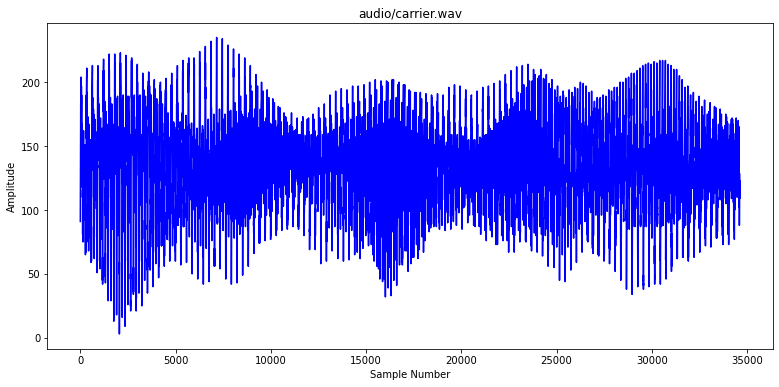

In [7]:
display(s1Filename)
s1, s1Rate = loadAudioAsMono(s1Filename)
display(Audio(s1, rate=s1Rate));

### Notes
- The file carrier.wav has only one channel (mono)
- Sampling rate is 12000 samples per second
- 34616 samples

## Load rockA.wav

'audio/rockA.wav'

'Read file: audio/rockA.wav 545652 samples, rate 44100'

'Converted to mono: audio/rockA.wav'

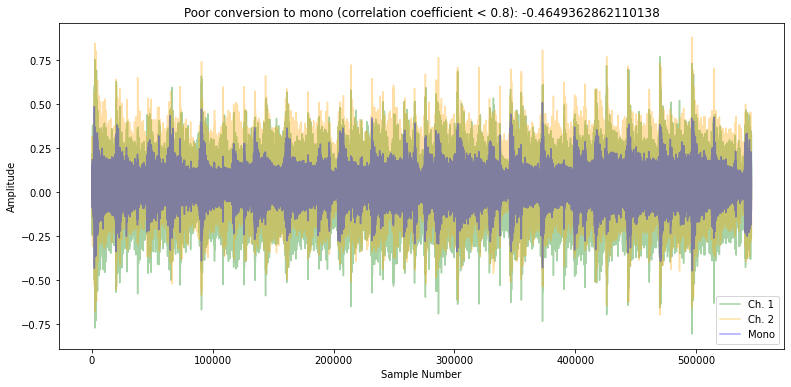

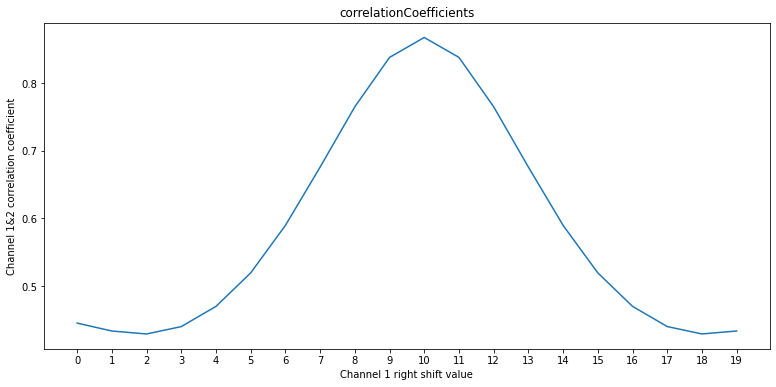

Max coefficient:  0.8673225107906857


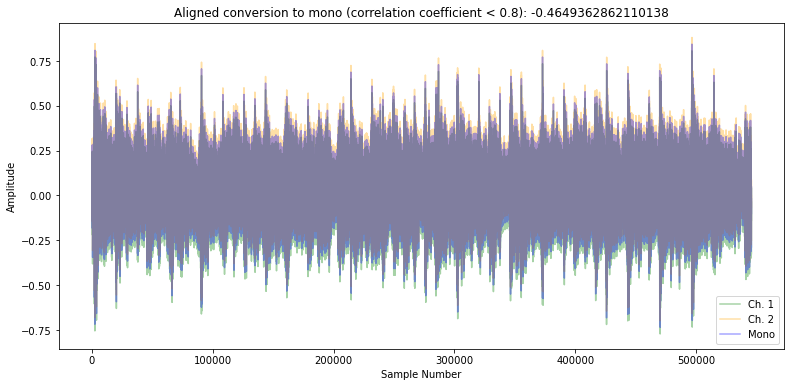

In [8]:
display(s2Filename)
s2, s2Rate = loadAudioAsMono(s2Filename)
display(Audio(s2, rate=s2Rate));

### Notes
- The file RockA.wav is stereo, 44100 samples per second sampling rate, 545652 samples per channel.
- The correlation coefficient of of the channels is poor: 0.4649.
- The plot displays the first audio channel, overlays the second audio channel, then finally overlays the result of
combining both channels to a single mono channel.
- The effect of the poor correlation between the two channels
is clearly visible.
- The file samples are corrected: channel 1 is inverted and shifted to the right by the number of samples that
give the highest correlation coefficient.
- The corrected stereo sample is converted to mono: The corrected stereo sample is plotted to show the effect of correcting the sample
before converting it to mono.
- After conversion there are 10 more samples, due to shifting one channel and zero padding the other.

## Load rockB.wav

'audio/rockB.wav'

'Read file: audio/rockB.wav 545652 samples, rate 44100'

'Converted to mono: audio/rockB.wav'

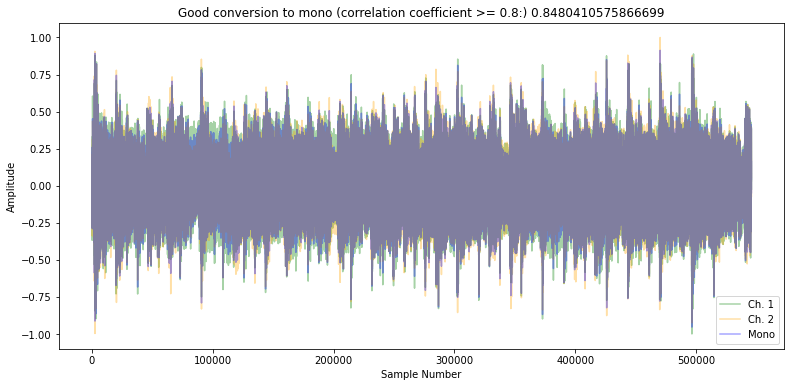

In [9]:
display(s3Filename)
s3, s3Rate = loadAudioAsMono(s3Filename)
display(Audio(s3, rate=s3Rate))

### Notes
- The file RockB.wav is stereo, 545652 samples per channel, 44100 samples/second sampling rate
- There is a good correlation (0.84804) between the two channels.
- The graph shows that the conversion closely
matches the two channels.
- The audio rendered is a good combination of both channels.

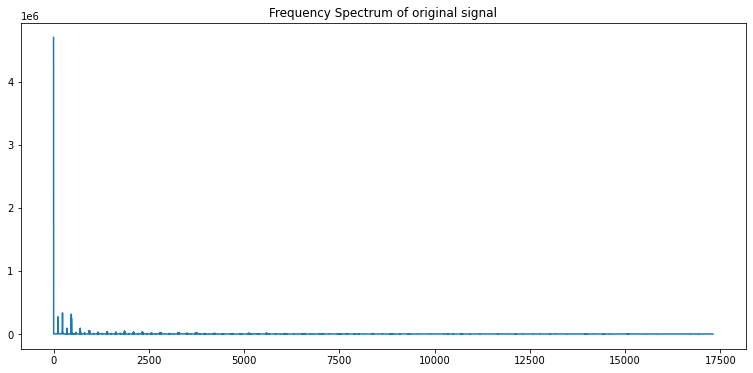

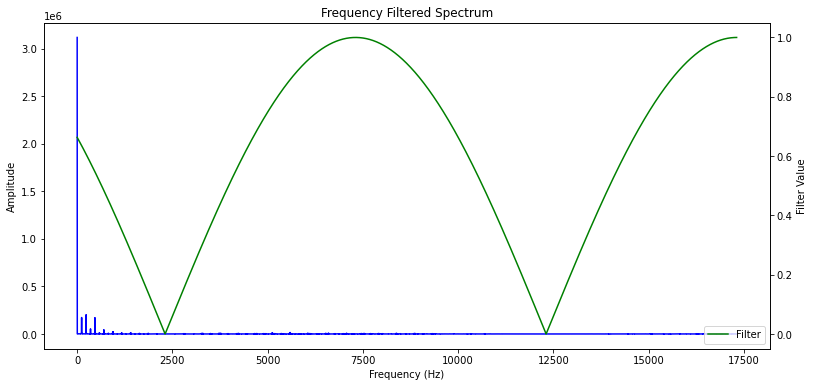

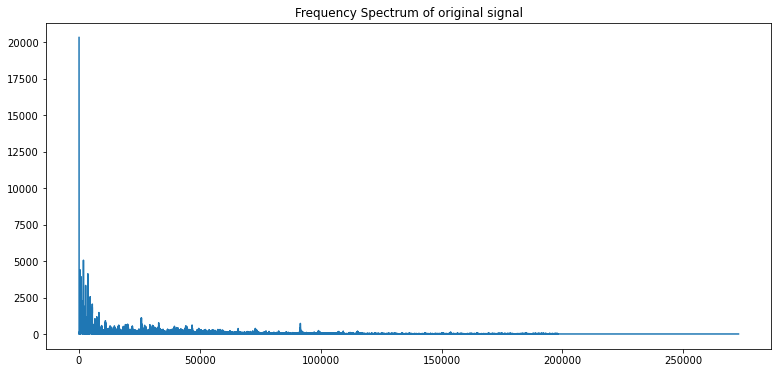

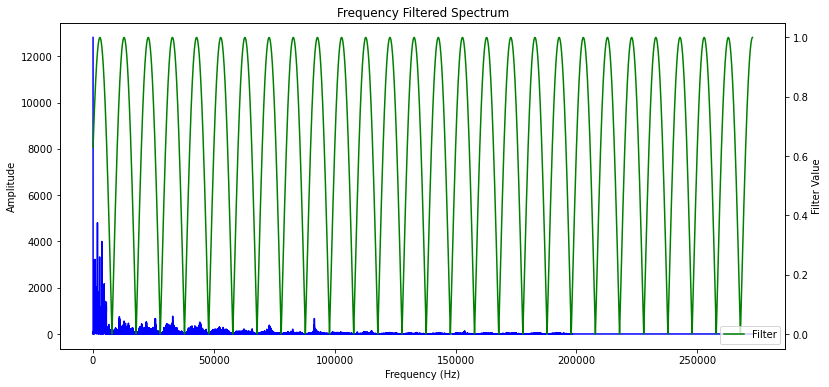

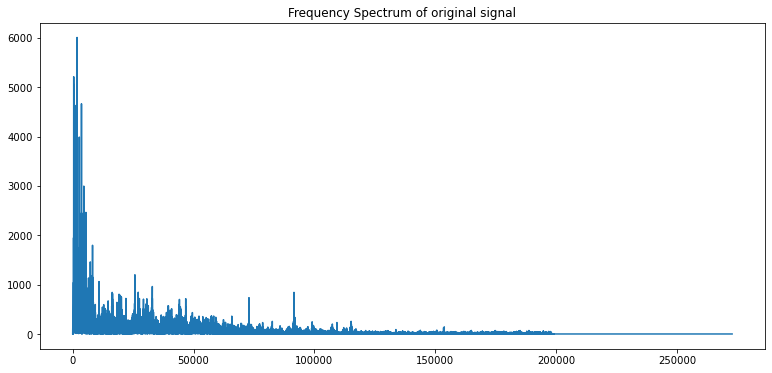

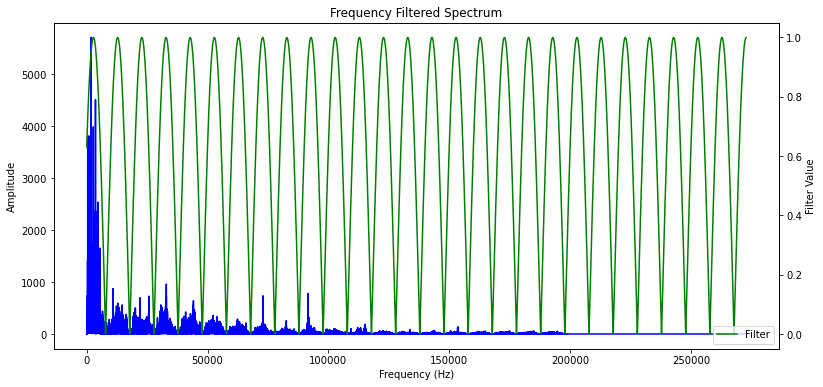

In [10]:
# Filter code
def filterAudio(samples, samplingRate, filename):
    spectrum = fft.rfft(samples)
    plt.figure()
    plt.title('Frequency Spectrum of original signal')
    plt.plot(np.abs(spectrum))
    plt.show()
    num_samples = len(samples)
    freq_response = np.abs(np.cos(2*np.pi*0.00005*np.arange(-num_samples/2, 1)))

    filtered_freq = spectrum * freq_response
    plt.figure()
    plt.title("Frequency Filtered Spectrum")
    plt.plot(np.abs(filtered_freq), 'b', label="Signal Frequencies");
    plt.xlabel("Frequency (Hz)");
    plt.ylabel("Amplitude");
    plt.twinx() # creates a new y-axis, because the range of y-values of spectrum and freq_response are too
            # so different that plotting them on the same graph would make freq_response invisible
    plt.plot(np.abs(freq_response), 'g', label="Filter")
    plt.xlabel("Frequency");
    plt.ylabel("Filter Value");
    plt.legend(loc = 4);
    plt.show()
    filtered_samples = fft.irfft(filtered_freq);
    display(Audio(filtered_samples, rate=samplingRate))
Test = False
if Test:
    filterAudio(s1, s1Rate, s1Filename)
    filterAudio(s2, s2Rate, s2Filename)
    filterAudio(s3, s3Rate, s3Filename)

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


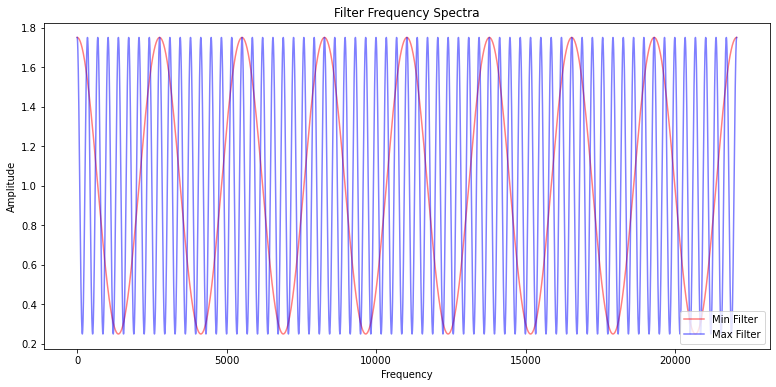

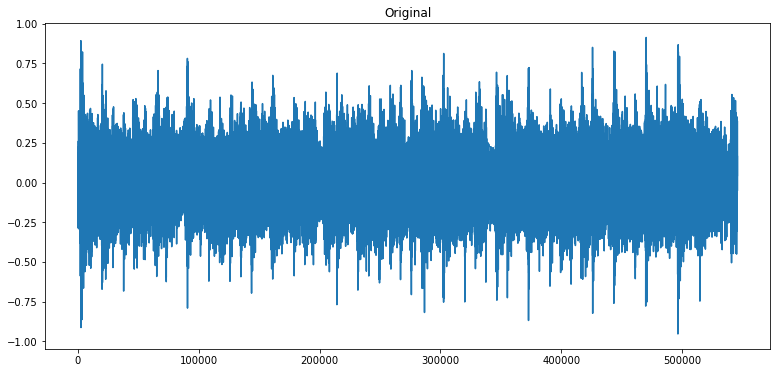

"\n    frequencyResponseSlow = np.abs(np.sin(2*np.pi*0.0002*np.arange(-5000, 1)))\n    plt.plot(frequencyResponseSlow, 'b');\n    slowFilterCoefficient = fft.irfft(frequencyResponseSlow);\n    frequencyResponseFast = np.abs(np.sin(2*np.pi*0.0055*np.arange(-5000, 1)))\n    fastFilterCoefficient = fft.irfft(frequencyResponseFast);\n    plt.plot(np.abs(frequencyResponseFast), 'r');\n    plt.show()\n    #plt.plot(slowFilterCoefficient[5000:195000], 'b');\n    plt.plot(np.abs(slowFilterCoefficient), 'b');\n    plt.show()\n    #plt.plot(slowFilterCoefficient[5000:195000], 'b');\n    plt.plot(np.abs(slowFilterCoefficient), 'b');\n    #plt.show()\n    #plt.plot(fastFilterCoefficient[5000:195000], 'r', alpha=0.5);\n    plt.plot(np.abs(fastFilterCoefficient), 'r', alpha=0.5);\n    plt.show()\n    return slowFilterCoefficient, fastFilterCoefficient\n"

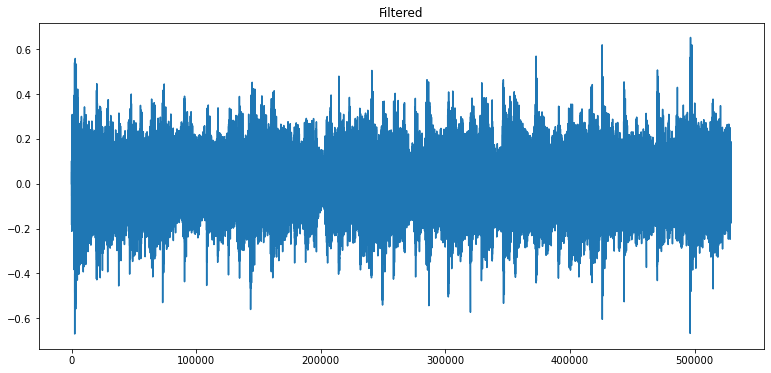

In [18]:
def createCombFilters(filterSize, minDelay, maxDelay):
    # impulse signal for filter1
    filterMin = np.zeros(filterSize)
    filterMin[0] = 1
    filterMin[minDelay] = 0.75
    # impulse signal for filter 2
    filterMax = np.zeros(filterSize)
    filterMax[0] = 1
    filterMax[maxDelay] = 0.75

    # plot the filters' frequency spectrum
    minFft = fft.rfft(filterMin)
    maxFft = fft.rfft(filterMax)
    plt.figure()
    plt.title("Filter Frequency Spectra")
    plt.plot(minFft, 'r', alpha=0.5, label='Min Filter')
    plt.plot(maxFft, 'b', alpha=0.5, label='Max Filter')
    plt.xlabel("Frequency")
    plt.ylabel('Amplitude')
    plt.legend(loc=4)
    plt.show()

    return filterMin, filterMax

def filterAudio(samples, sampleRate, filterMin, filterMax):
    windowSteps = int(len(samples) / len(filterMin))
    stepSize = len(filterMin)
    newSamples = np.zeros(1)
    filter = filterMin
    for step in range(windowSteps):
        sampleWindowStart = step * stepSize
        sampleWindow = samples[sampleWindowStart:sampleWindowStart+stepSize]
        conv_samples = signal.convolve(sampleWindow, np.concatenate([filter, filter]), mode='same')/2
        newSamples = np.concatenate([newSamples, conv_samples])
        if step % 2 > 0:
            filter = filterMax
        else:
            filter = filterMin
    plt.plot(samples)
    plt.title("Original")
    plt.show()
    plt.plot(newSamples)
    plt.title("Filtered")
    return newSamples

Test = True
if Test:
    filterMin, filterMax = createCombFilters(44100, 16, 128)
    newSamples = filterAudio(s3, s3Rate, filterMin, filterMax)
    display(Audio(newSamples, rate=s3Rate))
'''
    frequencyResponseSlow = np.abs(np.sin(2*np.pi*0.0002*np.arange(-5000, 1)))
    plt.plot(frequencyResponseSlow, 'b');
    slowFilterCoefficient = fft.irfft(frequencyResponseSlow);
    frequencyResponseFast = np.abs(np.sin(2*np.pi*0.0055*np.arange(-5000, 1)))
    fastFilterCoefficient = fft.irfft(frequencyResponseFast);
    plt.plot(np.abs(frequencyResponseFast), 'r');
    plt.show()
    #plt.plot(slowFilterCoefficient[5000:195000], 'b');
    plt.plot(np.abs(slowFilterCoefficient), 'b');
    plt.show()
    #plt.plot(slowFilterCoefficient[5000:195000], 'b');
    plt.plot(np.abs(slowFilterCoefficient), 'b');
    #plt.show()
    #plt.plot(fastFilterCoefficient[5000:195000], 'r', alpha=0.5);
    plt.plot(np.abs(fastFilterCoefficient), 'r', alpha=0.5);
    plt.show()
    return slowFilterCoefficient, fastFilterCoefficient
'''

# control signal must be sine, 2Hz



## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [ ]:
%ls data/digits-*.txt

In [ ]:
from itertools import islice
import re

def read_digit_pixels_and_labels(path):
    with open(path) as f:
        header = list(islice(f, 21))
        pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
        num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
        digit_pixels = []
        labels = []
        for _ in range(num_digits):
            chunk = list(islice(f, pixel_height+1))
            digit_pixels.append(np.loadtxt(chunk[:-1]))
            labels.append(int(chunk[-1]))
    return digit_pixels, labels

Since the text files have a custom format, a loader function `read_digit_pixels_and_labels` is provided.

In [ ]:
training_digits, training_labels = read_digit_pixels_and_labels('data/digits-training.txt')
test_digits, test_labels = read_digit_pixels_and_labels('data/digits-test.txt')

In [ ]:
len(training_digits), len(training_labels), len(test_digits), len(test_labels)

All digits and their associated labels have now been read into lists, so we can use list indexing to access them and, for instance, display them as below.

In [ ]:
index = 1
plt.figure()
plt.imshow(training_digits[index])
plt.show()
print('Image of digit {}'.format(training_labels[index]))

Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

In [ ]:
# write your code here

## Time series prediction with financial data (UG pairs & PG)

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [ ]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [ ]:
financial.dtype.names

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [ ]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

In [ ]:
plt.figure()
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

In [ ]:
# write your code here